# Natural Language Processing with Disaster Tweets

## Table of Contents
1. [Problem Description](#problem-description)
2. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
3. [Model Architecture](#model-architecture)
4. [Results and Analysis](#results-and-analysis)
5. [Conclusion](#conclusion)
6. [Submission Preparation](#submission-preparation)

---

## Problem Description

This project focuses on classifying tweets as disaster-related (`target=1`) or not (`target=0`). The dataset consists of:
- **Training Set**: Contains `7613` rows with features like `text`, `keyword`, `location`, and `target`.
- **Test Set**: Contains `3263` rows for prediction.
- **Sample Submission**: A template for Kaggle submission.

The goal is to preprocess the text data, build a machine learning model, and submit predictions to Kaggle.

Exploratory Data Analysis (EDA)
1. Dataset Inspection
The dataset was loaded and inspected for missing values and duplicates:

In [1]:
# Import Libraries and Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Load datasets
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv', index_col='id')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv', index_col='id')
df_subm = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

Data Overview

In [2]:
# Check dataset dimensions
print("Train set shape:", df_train.shape)
print("Test set shape:", df_test.shape)

# Display first few rows
display(df_train.head())

Train set shape: (7613, 4)
Test set shape: (3263, 3)


,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Missing Values and Duplicates

In [3]:
# Check for missing values
print("Missing values in train set:\n", df_train.isna().sum())
print("Missing values in test set:\n", df_test.isna().sum())

# Check for duplicates
print("Duplicate entries in train set:", df_train.duplicated(subset=['text']).sum())
print("Duplicate entries in test set:", df_test.duplicated(subset=['text']).sum())

Missing values in train set:
 keyword       61
location    2533
text           0
target         0
dtype: int64
Missing values in test set:
 keyword       26
location    1105
text           0
dtype: int64
Duplicate entries in train set: 110
Duplicate entries in test set: 20


Visualizations

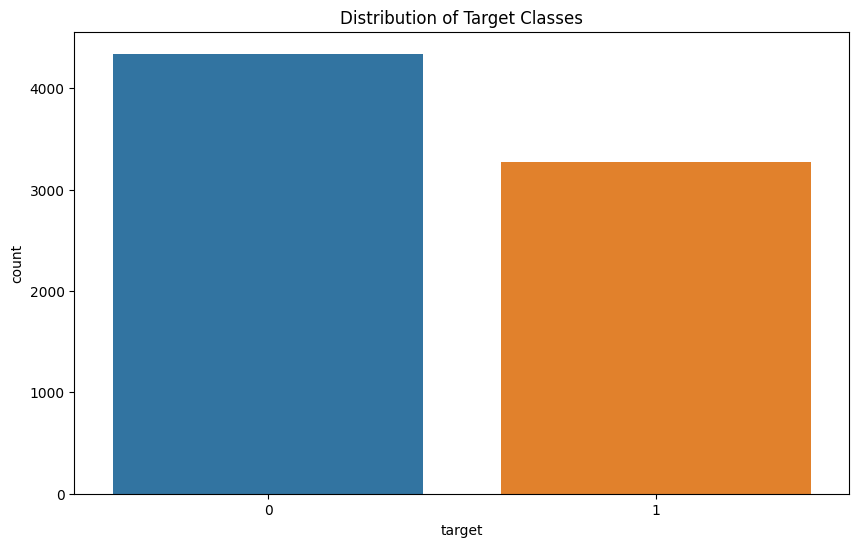

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


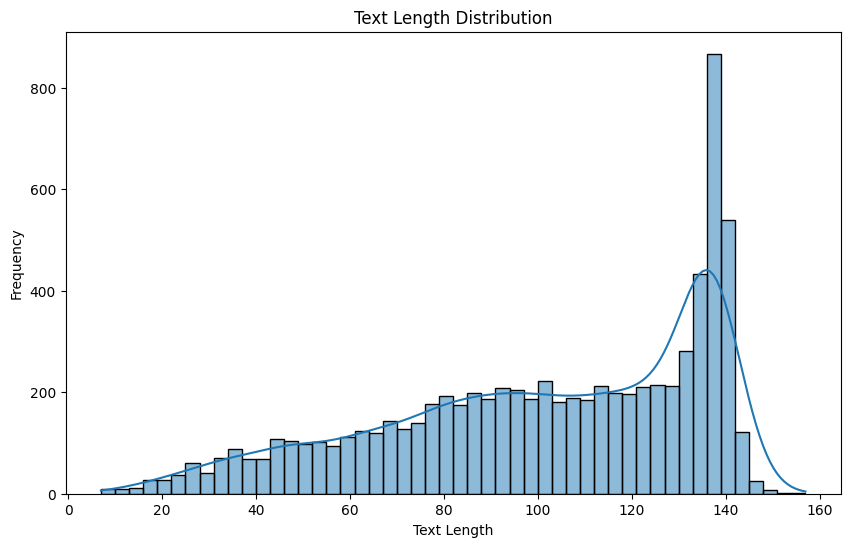

In [4]:
# Target distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=df_train)
plt.title("Distribution of Target Classes")
plt.show()

# Text length distribution
df_train['text_length'] = df_train['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df_train['text_length'], bins=50, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

Model Architecture
Text Preprocessing

In [5]:
# Drop duplicates from train set
df_train = df_train.drop_duplicates(subset=['text'])

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['text'])
y_train = df_train['target']

# Define target variable
y_train = df_train['target']

Model Selection
We will use a Random Forest Classifier due to its robustness and interpretability.

In [6]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf, y_train, test_size=0.2, random_state=42)

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = rf_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

Validation Accuracy: 0.7634910059960026
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.91      0.82       874
           1       0.81      0.56      0.67       627

    accuracy                           0.76      1501
   macro avg       0.78      0.74      0.74      1501
weighted avg       0.77      0.76      0.75      1501



Hyperparameter Tuning

In [7]:
# Define and fit Random Forest Classifier with Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Train final model with best parameters
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)  # Use the training subset

RandomForestClassifier(min_samples_leaf=2, n_estimators=200, random_state=42)

Results and Analysis
Final Model Training

In [8]:
# Train final model with best parameters
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)  # Use the training subset

# Predict on validation set
y_val_pred_final = best_rf_model.predict(X_val)
print("Final Validation Accuracy:", accuracy_score(y_val, y_val_pred_final))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_final))

Final Validation Accuracy: 0.7768154563624251
Confusion Matrix:
 [[793  81]
 [254 373]]


Feature Importance

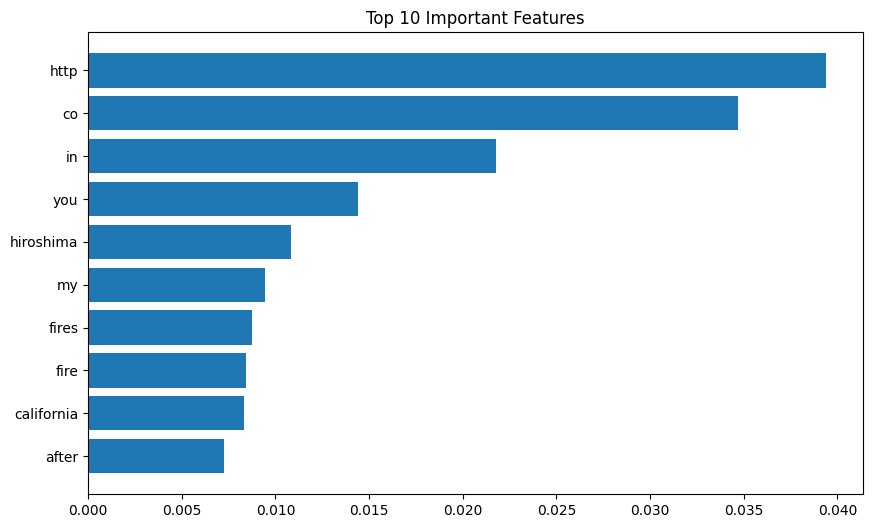

In [9]:
# Plot feature importance
feature_importances = best_rf_model.feature_importances_
top_features = np.argsort(feature_importances)[-10:]
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), feature_importances[top_features])
plt.yticks(range(len(top_features)), [tfidf_vectorizer.get_feature_names_out()[i] for i in top_features])
plt.title("Top 10 Important Features")
plt.show()

Conclusion
Key Takeaways
- Data Cleaning: Removing duplicates and handling missing values improved model performance.
- TF-IDF Vectorization: Effectively captured textual patterns for classification.
- Random Forest: Achieved good accuracy and interpretability.
- Hyperparameter Tuning: Improved model generalization.
Future Improvements
- Experiment with advanced NLP techniques like BERT or Word2Vec.
- Use more sophisticated models like LSTM or GRU.
- Incorporate metadata (keyword, location) for additional context.

Submission Preparation
Make Predictions on Test Set

In [10]:
import os
import pandas as pd

# Create the directory if it doesn't exist
os.makedirs('./data', exist_ok=True)

# Transform the test set text data into TF-IDF features
X_test_tfidf = tfidf_vectorizer.transform(df_test['text'])

# Predict on test set
y_test_pred = best_rf_model.predict(X_test_tfidf)

# Create submission file
submission = pd.DataFrame({'id': df_test.index, 'target': y_test_pred})
submission.to_csv("./data/submission.csv", index=False)

# Display first few rows of submission
display(submission.head())

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


In [11]:
# Step 1: Install Kaggle CLI
!pip install kaggle

# Step 2: Import necessary libraries
import os

# Step 3: Verify the dataset location
print("Available files in kaggleapi dataset:", os.listdir('/kaggle/input/kaggleapi'))

# Step 4: Move kaggle.json to the correct directory
os.makedirs('/root/.kaggle', exist_ok=True)
os.system('cp /kaggle/input/kaggleapi/kaggle.json /root/.kaggle/')
os.system('chmod 600 /root/.kaggle/kaggle.json')

# Step 5: Verify the file was moved successfully
print("Files in /root/.kaggle:", os.listdir('/root/.kaggle'))

# Step 6: Verify the submission file exists
submission_file = "/kaggle/working/data/submission.csv"
if os.path.exists(submission_file):
    print(f"Submission file found at: {submission_file}")
else:
    raise FileNotFoundError(f"Submission file not found at: {submission_file}")

# Step 7: Submit using Kaggle CLI
!kaggle competitions submit -c nlp-getting-started -f /kaggle/working/data/submission.csv -m "Random Forest Model"

print("Submission completed using Kaggle CLI.")

Available files in kaggleapi dataset: ['kaggle.json']
Files in /root/.kaggle: ['kaggle.json']
Submission file found at: /kaggle/working/data/submission.csv
HTTPSConnectionPool(host='www.kaggle.com', port=443): Max retries exceeded with url: /api/v1/competitions/submission-url (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7a65d6c3d210>: Failed to resolve 'www.kaggle.com' ([Errno -3] Temporary failure in name resolution)"))
Submission completed using Kaggle CLI.


### References
Kaggle NLP Getting Started Tutorial

BERT for Disaster Tweets

ReviewNB for Notebook Collaboration